# Clustering on simulated trajectories

This script simulates a user trajectory and GPS pings produced at different frequencies. We generate synthetic trajectories simulating two hour-long visits to adjacent 90m-radius locations, separated by a 5-minute walk, followed by a 3-hour visit to a 180m-radius location a 15-minute walk away. We sample signals at low (3 Pings/Hour) and high (12 Pings/Hour) frequencies using a self-exciting point (Hawkes) process along with some noise representing horizontal inaccuracies in GPS data

We apply two parameterizations of our “TS-DBScan” algorithm: “coarse” with parameters given by distance threshold d = 120 meters, time threshold t = 120 minutes, and minimum number of points N = 2; and “fine” with parameters given by distance threshold d = 75 meters, time threshold t = 60 minutes, and minimum number of points N = 3.

We likewise consider two parameterizations of our “Project Lachesis” algorithm: “coarse” with parameters given by minimum stay duration dur_min = 10 minutes, maximum ping gap dt_max = 120 minutes, and maximum roaming distance d = 400 meters; and “fine” with parameters given by minimum stay duration dur_min = 10 minutes, maximum ping gap dt_max = 60 minutes, and maximum roaming distance d = 150 meters.

In [26]:
!pip install tick

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib import cm

import sys
import os
core_dir = os.path.join(os.getcwd(), '..', 'core')
core_dir = os.path.normpath(core_dir)
sys.path.append(core_dir)

import mobility_model as mmod
import stop_detection as sd

import pdb

### Trajectory Simulation
We simulate a user's trajectory using Brownian motion and sample from this trajectory via a Hawkes process to obtain sparse pings. 

Define trajectory stays (center, radius, duration) and moves (duration) between stays.

In [27]:
mu_0 = np.array([-100,110])
mu_1 = np.array([0,-110])
mu_2 = np.array([950,0])

r_0 = 90
r_1 = 90
r_2 = 180

t_0 = 60
t_1 = 60
t_2 = 180

p = 0.2

eps = 10

stays = [(mu_0, r_0, t_0, p), (mu_1, r_1, t_1, p), (mu_2, r_2, t_2, p)]
moves = [5, 15]

params = [(240, 120, 2), (60, 75, 3)]

Animation of the (pre-sampled) simulated trajectory.

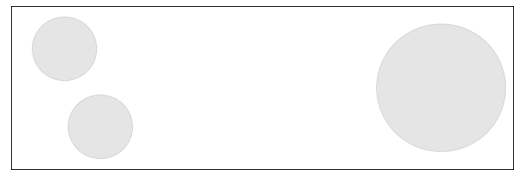

In [28]:
from matplotlib.animation import FuncAnimation, PillowWriter

data = mmod.simulate_traj(stays, moves, seed=110)
fig, ax = plt.subplots(figsize=(9, 3))

patches = [Circle(mu_0, r_0, color='gray', alpha=0.2),
           Circle(mu_1, r_1, color='gray', alpha=0.2),
           Circle(mu_2, r_2, color='gray', alpha=0.2)]

for p in patches:
    ax.add_patch(p)

ax.set_xlim((-250, 1150))
ax.set_ylim((-230, 230))
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

line, = ax.plot([], [], color='blue', alpha=0.1)
scatter = ax.scatter([], [], s=8, color='black', alpha=0.5)
time_text = ax.text(0.35, 0.85, '', transform=ax.transAxes)

def update(i):
    line.set_data(data['x'][:i], data['y'][:i])
    scatter.set_offsets(data[['x', 'y']][:i])
    time_text.set_text(data['local_timestamp'][i].strftime('%Y-%m-%d %H:%M:%S'))
    return line, scatter

# anim = FuncAnimation(fig, update, frames=len(data), interval=50, blit=True)
# anim.save('trajectory_animation.gif', writer=PillowWriter(fps=20))
# plt.close(fig)

Animation of the sampled simulated trajectory.

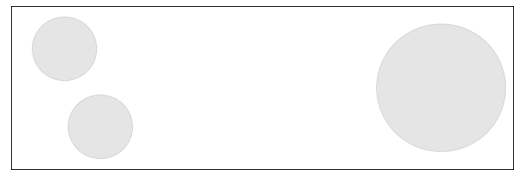

In [29]:
data = mmod.simulate_traj(stays, moves, seed=110)
data = mmod.sample_traj(data, 0, seed=110)
fig, ax = plt.subplots(figsize=(9, 3))

patches = [Circle(mu_0, r_0, color='gray', alpha=0.2),
           Circle(mu_1, r_1, color='gray', alpha=0.2),
           Circle(mu_2, r_2, color='gray', alpha=0.2)]

for p in patches:
    ax.add_patch(p)

ax.set_xlim((-250, 1150))
ax.set_ylim((-230, 230))
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

points, = ax.plot([], [], 'o', color='black', alpha=0.5)
time_text = ax.text(0.35, 0.85, '', transform=ax.transAxes)

timestamps_to_plot = pd.date_range(start='2022-01-01 00:00:00', end='2022-01-01 05:19:00', freq='min')
points_dict = {str(timestamp): data[(data['local_timestamp'] >= timestamp) & 
                                    (data['local_timestamp'] < timestamp + pd.Timedelta(seconds=1))]
               for timestamp in timestamps_to_plot}

def update(current_time):
    current_data = data[data['local_timestamp'] <= current_time]
    if not current_data.empty:
        points.set_data(current_data['x'], current_data['y'])
    time_text.set_text(current_time.strftime('%Y-%m-%d %H:%M:%S'))
    return points,

# anim = FuncAnimation(fig, update, frames=timestamps_to_plot, interval=50, repeat=False)
# anim.save('sampling_animation.gif', writer=PillowWriter(fps=20))
# plt.close(fig)

PLOT: Sampled points overlaid on ground truth

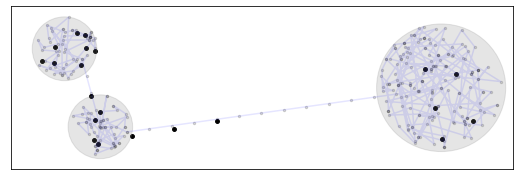

In [30]:
%matplotlib inline

seed=110
traj = mmod.simulate_traj(stays, moves, seed=seed)
pings = mmod.sample_traj(traj, 0, seed=seed)

fig, ax = plt.subplots(figsize=(9, 3))

patches = [Circle(mu_0, r_0, color='gray', alpha=0.2),
           Circle(mu_1, r_1, color='gray', alpha=0.2),
           Circle(mu_2, r_2, color='gray', alpha=0.2)]

for p in patches:
    ax.add_patch(p)

ax.plot(traj.x, traj.y, color='blue', alpha=0.1) 
ax.scatter(traj.x, traj.y, s=6, color='black', alpha=0.15)

#ax.plot(pings.x, pings.y, color='red', alpha=0.5) 
ax.scatter(pings.x, pings.y, s=15, color='black', alpha=1)
    
ax.set_xlim((-250,1150))
ax.set_ylim((-230, 230))
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

plt.show()

In [1]:
import numpy as np
60/np.sqrt(2)

42.426406871192846

In [2]:
np.sqrt(1000)*0.3

9.486832980505138

## Metrics

In [45]:
# user-level stop table: 
def generate_stop_table(data, dbscan_df):
    """
    TODO: user id, ts, duration, centroid coord, max time gap, radius, etc.
    
    Returns
    -------
    TODO
    """    
    num_clusters = sum(dbscan_df.cluster.unique() > -1)
    
    stop_table = []

    total_stop_time = 0
    
    for cid in range(num_clusters):
        cpings = dbscan_df[dbscan_df.cluster == cid]
        cdata = data.loc[cpings.index]
        duration = int((cdata.index.max() - cdata.index.min()) // 60)
        n = len(cdata)
        x_mean = np.mean(cdata['x'])
        y_mean = np.mean(cdata['y'])
        radius = np.sqrt(np.mean(np.sum((cdata[['x','y']].to_numpy() 
                                         - np.mean(cdata[['x','y']].to_numpy(), axis=0))**2, axis=1)))
        row = [duration, x_mean, y_mean, radius]
        stop_table += row
    
    return pd.DataFrame(stop_table)

def stop_statistics(data, dbscan_df):
    """
    TODO: user-level metrics: number of clusters, radius of gyration,
    time resolution param? 
    """
    num_clusters = sum(dbscan_df.cluster.unique() > -1)
    total_stop_time = 0
    
    for cid in range(num_clusters):
        cpings = dbscan_df[dbscan_df.cluster == cid]
        cdata = data.loc[cpings.index]
        duration = int((cdata.index.max() - cdata.index.min()) // 60)
        n = len(cdata)
        x_mean = np.mean(cdata['x'])
        y_mean = np.mean(cdata['y'])
        radius = np.sqrt(np.mean(np.sum((cdata[['x','y']].to_numpy() 
                                         - np.mean(cdata[['x','y']].to_numpy(), axis=0))**2, axis=1)))
        
        total_stop_time += duration

    return [num_clusters, total_stop_time]

In [46]:
seed=434
data = mmod.simulate_traj(stays, moves, seed=seed)
data = mmod.sample_traj(data, 1, seed=seed)
data = data.set_index('unix_timestamp', drop=False)
dbscan_df = sd.temporal_dbscan(data, *params[1])

generate_stop_table(data, dbscan_df)

,0
0,157.000000
1,944.330581
2,67.503865
3,87.558589
4,56.000000
5,12.344395
6,-114.895509
7,58.653469
8,59.000000
9,-89.942616


## Test clustering and plotting: DBSCAN

PLOT: Cores plotted as triangles.

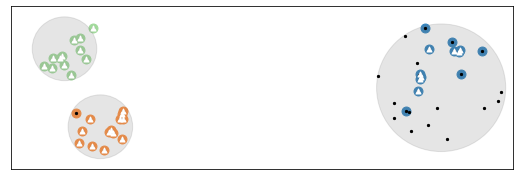

In [33]:
seed=434
df = mmod.simulate_traj(stays, moves, seed=seed)
df = mmod.sample_traj(df, 1, seed=seed)
df = df.set_index('unix_timestamp', drop=False)

dbscan_df = sd.temporal_dbscan(df, *params[1])

fig, ax = plt.subplots(figsize=(9, 3))

patches = [Circle(mu_0, r_0, color='gray', alpha=0.2),
           Circle(mu_1, r_1, color='gray', alpha=0.2),
           Circle(mu_2, r_2, color='gray', alpha=0.2)]

for p in patches:
    ax.add_patch(p)
            
all_cores = pd.DataFrame()
num_clusters = sum(dbscan_df.cluster.unique() > -1)
        
for cid in range(num_clusters):
    cpings = dbscan_df[dbscan_df.cluster == cid]
    cdata = df.loc[cpings.index]
    col = cm.tab20c(cid/(num_clusters+1))
    ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=1)
    
    cores = cdata.loc[cpings.core != -1]
    all_cores = all_cores.append(cores)

ax.scatter(df.x, df.y, s=5, color='black', alpha=1, zorder=2)
ax.scatter(all_cores.x, all_cores.y, marker = '^', s=25, color='white', alpha=1, zorder=3)

ax.set_xlim((-250,1150))
ax.set_ylim((-230, 230))

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

plt.savefig("plot_cores.png")
plt.show()

PLOT: Temporal plot by clusters

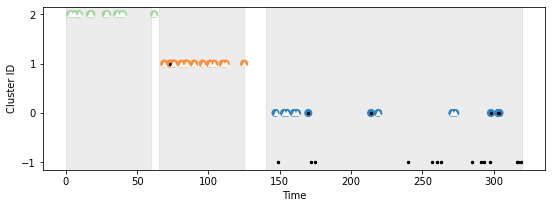

In [34]:
seed=434
df = mmod.simulate_traj(stays, moves, seed=seed)
df = mmod.sample_traj(df, 1, seed=seed)
df = df.set_index('unix_timestamp', drop=False)
dbscan_df = sd.temporal_dbscan(df, *params[1])

dbscan_df['time'] = (dbscan_df.index - 1640995200) // 60

cluster_df = dbscan_df[dbscan_df['cluster']!=-1]
noise_df   = dbscan_df[dbscan_df['cluster']==-1]
noncore_df = dbscan_df[dbscan_df['core']==-1]
core_df    = dbscan_df[dbscan_df['core']!=-1]

num_clusters = sum(dbscan_df.cluster.unique() > -1)

plt.figure(figsize=(9, 3))
plt.scatter(cluster_df['time'], cluster_df['cluster'], s=50, c=cm.tab20c(cluster_df['cluster']/(num_clusters+1)), zorder=2)
plt.scatter(noncore_df['time'], noncore_df['cluster'], s=5, color='black', alpha=1, zorder=3)
plt.scatter(noise_df['time'], noise_df['cluster'], s=5, color='black', alpha=1, zorder=3)
plt.scatter(core_df['time'], core_df['cluster'], marker = '^', s=20, c="white", zorder=4)

# Horizontal bars denoting ground truth stays
stay_durations = [(140, 320), (65, 125), (0, 60)]
for start, end in stay_durations:
    plt.axvspan(start, end, color='grey', alpha=0.15, zorder=1)

plt.xlabel('Time')
plt.ylabel('Cluster ID')
plt.yticks(range(-1,num_clusters))

plt.savefig("plot_time.png")
plt.show()

PLOT: Core points with their neighbors

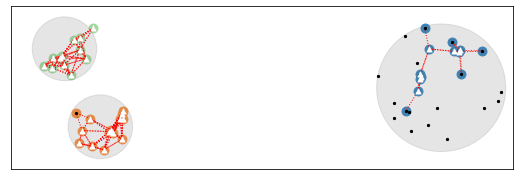

In [35]:
seed=434
df = mmod.simulate_traj(stays, moves, seed=seed)
df = mmod.sample_traj(df, 1, seed=seed)
df = df.set_index('unix_timestamp', drop=False)

dbscan_df = sd.temporal_dbscan(df, *params[1])
neighbor_dict = sd.find_neighbors(df, 60, 75)

fig, ax = plt.subplots(figsize=(9, 3))

patches = [Circle(mu_0, r_0, color='gray', alpha=0.2),
           Circle(mu_1, r_1, color='gray', alpha=0.2),
           Circle(mu_2, r_2, color='gray', alpha=0.2)]

for p in patches:
    ax.add_patch(p)
    
all_cores = pd.DataFrame()
num_clusters = sum(dbscan_df.cluster.unique() > -1)
        
for cid in range(num_clusters):
    cpings = dbscan_df[dbscan_df.cluster == cid]
    cdata = df.loc[cpings.index]
    col = cm.tab20c(cid/(num_clusters+1))
    ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=1)
    
    cores = cdata.loc[cpings.core != -1]
    all_cores = all_cores.append(cores)
    
min_points = 3
    
# iter through all_cores
for point in all_cores.index:
    
    neighbors = neighbor_dict[point]
    
    if (len(neighbors) >= min_points): # core point
        point_coord = df[df['unix_timestamp'] == point]

        for neighbor_timestamp in neighbors:
            neighbor_point = df[df['unix_timestamp'] == neighbor_timestamp]

            plt.plot([point_coord['x'].values[0], neighbor_point['x'].values[0]],
                     [point_coord['y'].values[0], neighbor_point['y'].values[0]],
                     'k:',  # k = black dotted line
                     linewidth=1,
                     color="red",
                     alpha=1,
                     zorder=1)

ax.scatter(df.x, df.y, s=5, color='black', alpha=1, zorder=3)
ax.scatter(all_cores.x, all_cores.y, marker = '^', s=25, color='white', alpha=1, zorder=4)
    
ax.set_xlim((-250,1150))
ax.set_ylim((-230, 230))

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

plt.savefig("plot_neighbors.png")
plt.show()

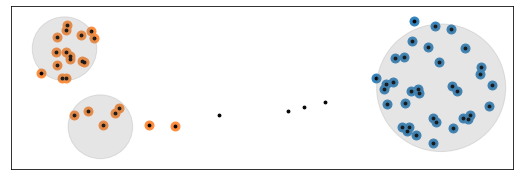

In [36]:
seed = 110
df = mmod.simulate_traj(stays, moves, seed=seed)
df = mmod.sample_traj(df, 1, seed=seed)
df = df.set_index('unix_timestamp', drop=False)

dbscan_df = sd.temporal_dbscan(df, *params[0])

fig, ax = plt.subplots(figsize=(9, 3))

patches = [Circle(mu_0, r_0, color='gray', alpha=0.2),
           Circle(mu_1, r_1, color='gray', alpha=0.2),
           Circle(mu_2, r_2, color='gray', alpha=0.2)]

for p in patches:
    ax.add_patch(p)

num_clusters = sum(dbscan_df.cluster.unique() > -1)

for cid in range(num_clusters):
    cpings = dbscan_df[dbscan_df.cluster == cid]
    cdata = df.loc[cpings.index]
    col = cm.tab20c(cid/(num_clusters+1))
    ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=1)
    
ax.scatter(df.x, df.y, s=8, color='black', alpha=1)
ax.set_xlim((-250,1150))
ax.set_ylim((-230, 230))
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

plt.show()

2x2 plots showing different configurations

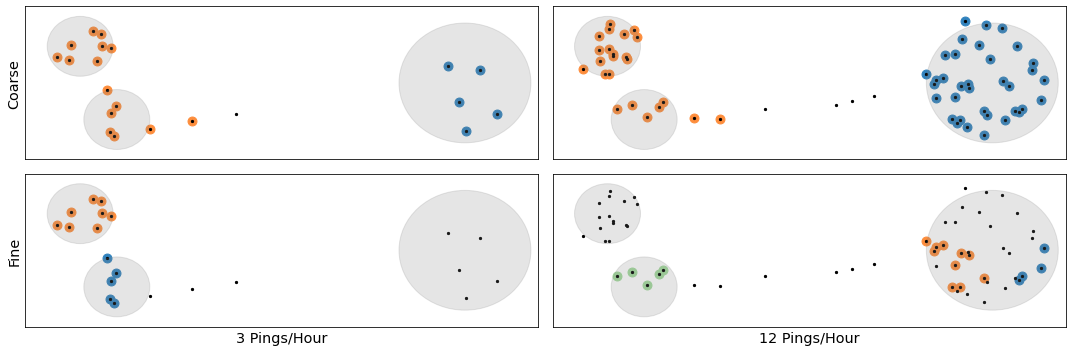

In [37]:
fig, axes = plt.subplots(2,2, figsize=(15, 5))

for i in range(2):
    for j in range(2):
        ax = axes[i,j]
        seed = 110  # 434
        df = mmod.simulate_traj(stays, moves, seed=seed)
        df = mmod.sample_traj(df, j, seed=seed)
        df = df.set_index('unix_timestamp', drop=False)

        dbscan_df = temporal_dbscan(df, *params[i])

        patches = [Circle(mu_0, r_0, color='gray', alpha=0.2),
                   Circle(mu_1, r_1, color='gray', alpha=0.2),
                   Circle(mu_2, r_2, color='gray', alpha=0.2)]
        for p in patches:
            ax.add_patch(p)

        for cid in range(num_clusters):
            cpings = dbscan_df[dbscan_df.cluster == cid]
            cdata = df.loc[cpings.index]
            col = cm.tab20c(cid/(num_clusters+1))
            ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=1)        

        ax.scatter(df.x, df.y, s=5, color='black', alpha=1)
        
        ax.set_xlim((-250,1150))
        ax.set_ylim((-230, 230))
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
    
axes[0,0].set_ylabel('Coarse', fontsize='x-large')
axes[1,0].set_ylabel('Fine', fontsize='x-large')
axes[1,0].set_xlabel('3 Pings/Hour', fontsize='x-large')
axes[1,1].set_xlabel('12 Pings/Hour', fontsize='x-large')

plt.tight_layout()
plt.savefig("stdbscan.png")
plt.show()

## Test clustering and plotting: Lachesis

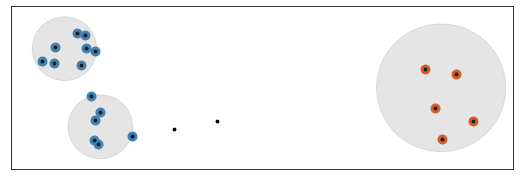

In [38]:
seed = 110
data = mmod.simulate_traj(stays, moves, seed=seed)
data = mmod.sample_traj(data, 0, seed=seed)
cluster_pings = sd.lachesis_patches(data, 0)
fig, ax = plt.subplots(figsize=(9, 3))

patches = [Circle(mu_0, r_0, color='gray', alpha=0.2),
           Circle(mu_1, r_1, color='gray', alpha=0.2),
           Circle(mu_2, r_2, color='gray', alpha=0.2)]

for p in patches:
    ax.add_patch(p)

for i, pings in enumerate(cluster_pings):
    col = cm.tab20c(i/5)
    ax.scatter(pings.x, pings.y, s=80, color=col, alpha=1)    
    
ax.scatter(data.x, data.y, s=8, color='black', alpha=1)
ax.set_xlim((-250,1150))
ax.set_ylim((-230, 230))
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

plt.show()

2x2 plots showing different configurations

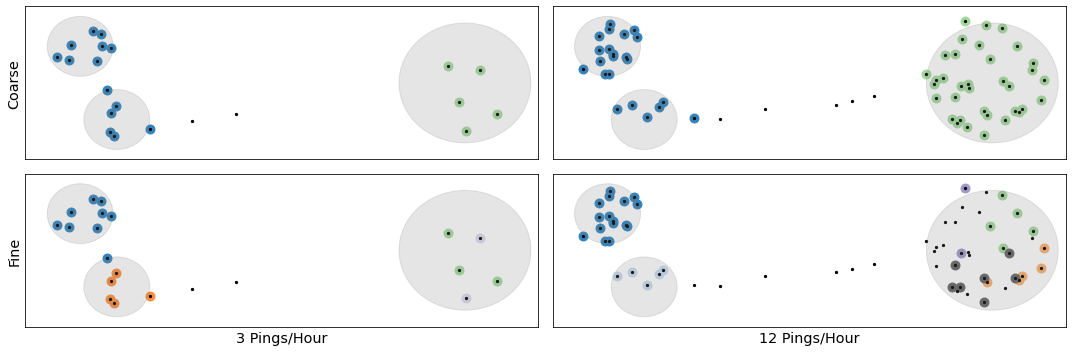

In [39]:
fig, axes = plt.subplots(2,2, figsize=(15, 5))

for i in range(2):
    for j in range(2):
        ax = axes[i,j]
        seed = 110
        df = mmod.simulate_traj(stays, moves, seed=seed)
        df = mmod.sample_traj(df, j, seed=seed)
        clusters = sd.lachesis_patches(df, i)

        patches = [Circle(mu_0, r_0, color='gray', alpha=0.2),
                   Circle(mu_1, r_1, color='gray', alpha=0.2),
                   Circle(mu_2, r_2, color='gray', alpha=0.2)]
        for p in patches:
            ax.add_patch(p)
        
        for idx, data in enumerate(clusters):
            col = cm.tab20c(idx/len(clusters))
            ax.scatter(data.x, data.y, s=80, color=col, alpha=1)          

        ax.scatter(df.x, df.y, s=5, color='black', alpha=1)
        
        ax.set_xlim((-250,1150))
        ax.set_ylim((-230, 230))
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

axes[0,0].set_ylabel('Coarse', fontsize='x-large')
axes[1,0].set_ylabel('Fine', fontsize='x-large')
axes[1,0].set_xlabel('3 Pings/Hour', fontsize='x-large')
axes[1,1].set_xlabel('12 Pings/Hour', fontsize='x-large')

plt.tight_layout()
plt.savefig("lachesis.png")
plt.show()